# Predicting Credit Card Defaults in Taiwan

**Author: Mitchell Krieger**

## Overview

To optimize returns, Banks must manage their risk when providing credit cards to customers. This project attempts to create a model that predicts if a client will or will not default on their loan. This project was a competition with classmates to see who could achieve the model with the best F-1 scores that predicts people who will default on a holdout dataset.


#### Data Set Information:

This datset comes from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients)


#### Data Dictionary:

This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables: 
- X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit. 
- X2: Gender (1 = male; 2 = female). 
- X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others). 
- X4: Marital status (1 = married; 2 = single; 3 = others). 
- X5: Age (year). 
- X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: 
    - X6 = the repayment status in September, 2005; 
    - X7 = the repayment status in August, 2005; . . .;
    - etc...
    - X11 = the repayment status in April, 2005. 
    - The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
- X12-X17: Amount of bill statement (NT dollar). 
    - X12 = amount of bill statement in September, 2005;
    - etc...
    - X13 = amount of bill statement in August, 2005; . . .; 
    - X17 = amount of bill statement in April, 2005. 
- X18-X23: Amount of previous payment (NT dollar). 
    - X18 = amount paid in September, 2005; 
    - X19 = amount paid in August, 2005; . . .;
    - etc...
    - X23 = amount paid in April, 2005. 


### Import relevant packages

In [68]:
# import libraries
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV, SelectKBest, f_regression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

import xgboost as xgb

pd.options.display.max_columns =25
pd.options.display.max_rows = 100

## 1. Data Cleaning
**Read in data and select column headers**

In [69]:
df = pd.read_csv('data/training_data.csv')

#Row 18381 contains column names
df.columns = df.iloc[18381]
df.columns = df.columns.str.replace(" ","_")
df.drop(labels=[18381],axis=0,inplace=True)
df.drop(columns=['ID'],inplace=True)
df.rename(columns={'PAY_0':'PAY_1','default_payment_next_month':'default'},inplace=True)
df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default'],
      dtype='object', name=18381)

**Set datatypes**

In [70]:
#set d types as int
for col in df.columns:
    df[col] = pd.to_numeric(df[col])
df.info() #no np.nan

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22499 entries, 0 to 22499
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   LIMIT_BAL  22499 non-null  int64
 1   SEX        22499 non-null  int64
 2   EDUCATION  22499 non-null  int64
 3   MARRIAGE   22499 non-null  int64
 4   AGE        22499 non-null  int64
 5   PAY_1      22499 non-null  int64
 6   PAY_2      22499 non-null  int64
 7   PAY_3      22499 non-null  int64
 8   PAY_4      22499 non-null  int64
 9   PAY_5      22499 non-null  int64
 10  PAY_6      22499 non-null  int64
 11  BILL_AMT1  22499 non-null  int64
 12  BILL_AMT2  22499 non-null  int64
 13  BILL_AMT3  22499 non-null  int64
 14  BILL_AMT4  22499 non-null  int64
 15  BILL_AMT5  22499 non-null  int64
 16  BILL_AMT6  22499 non-null  int64
 17  PAY_AMT1   22499 non-null  int64
 18  PAY_AMT2   22499 non-null  int64
 19  PAY_AMT3   22499 non-null  int64
 20  PAY_AMT4   22499 non-null  int64
 21  PAY_AMT5   2

**Checking for other kinds of missing values**

Map education values not in dictionary to 4 indicating "other" education

In [71]:
conditions = [df.EDUCATION == 0,
             df.EDUCATION == 6,
             df.EDUCATION == 5]

choices = [4,4,4]

df.EDUCATION = np.select(conditions,choices,default=df.EDUCATION)


Map marriage values not in dictionary to 3 indicating "other" marital status

In [72]:
df.MARRIAGE = np.where(df.MARRIAGE ==0,3,df.MARRIAGE)
df.MARRIAGE.value_counts()

2    12026
1    10195
3      278
Name: MARRIAGE, dtype: int64

## 2. EDA

First look at mean values to look to get a basic sense of data:

In [73]:
df.mean()

18381
LIMIT_BAL    167054.521534
SEX               1.603227
EDUCATION         1.844260
MARRIAGE          1.559225
AGE              35.447931
PAY_1            -0.014090
PAY_2            -0.128806
PAY_3            -0.160185
PAY_4            -0.214587
PAY_5            -0.259700
PAY_6            -0.287613
BILL_AMT1     51455.869416
BILL_AMT2     49385.313214
BILL_AMT3     47042.127161
BILL_AMT4     43329.149562
BILL_AMT5     40306.373039
BILL_AMT6     38955.000356
PAY_AMT1       5627.914796
PAY_AMT2       5964.392773
PAY_AMT3       5258.912307
PAY_AMT4       4792.971777
PAY_AMT5       4865.656029
PAY_AMT6       5247.279301
default           0.223477
dtype: float64

Right off the bat it is easy to see that the average bill is much higher than the average payment, this means that people are much more likely to pay the minimum required than what's fully due. In addition, the credit limit is mych higher than both the monthly bill and the monthly payment.

Now let's take a quick look at the distribution of features:

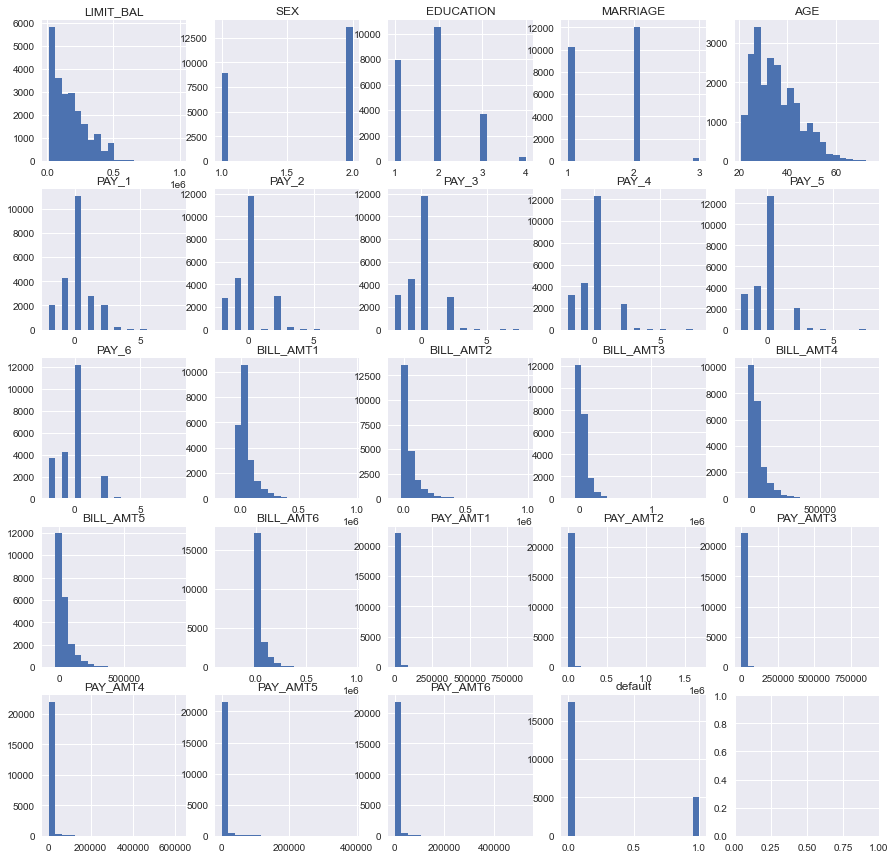

In [74]:
fig, ax = plt.subplots(nrows=5,ncols=5,figsize=(15,15))

# sns.distplot(df.ID)

for i, col in enumerate(df.columns):
    df[col].hist(ax=ax[i//5][i%5],bins=20)
    ax[i//5][i%5].set_title(col)

A few key things to note:
- Again, seems like payments are much smaller than bills
- For the most part the max limit is \$500000 with a few outliers but most people have a limit less than that
- Most people pay in full or if not in full at least on time (`PAY_X` <1)

### How many people default on their credit card payment?

About 22% of the people in data defaulted on payments

0    17471
1     5028
Name: default, dtype: int64
0    0.776523
1    0.223477
Name: default, dtype: float64


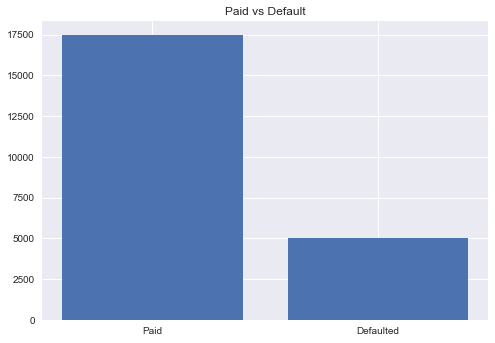

In [75]:
y = df.default
print(y.value_counts())
print(y.value_counts(normalize=True))
plt.style.use('seaborn')
plt.bar(['Paid','Defaulted'],y.value_counts())
plt.title('Paid vs Default')

plt.savefig('./images/paid_v_default.png')

### Amount paid vs Month paid

Based on the plots below it looks like the more late a bill is paid, the smaller the amount paid (possibly close to the minimum)

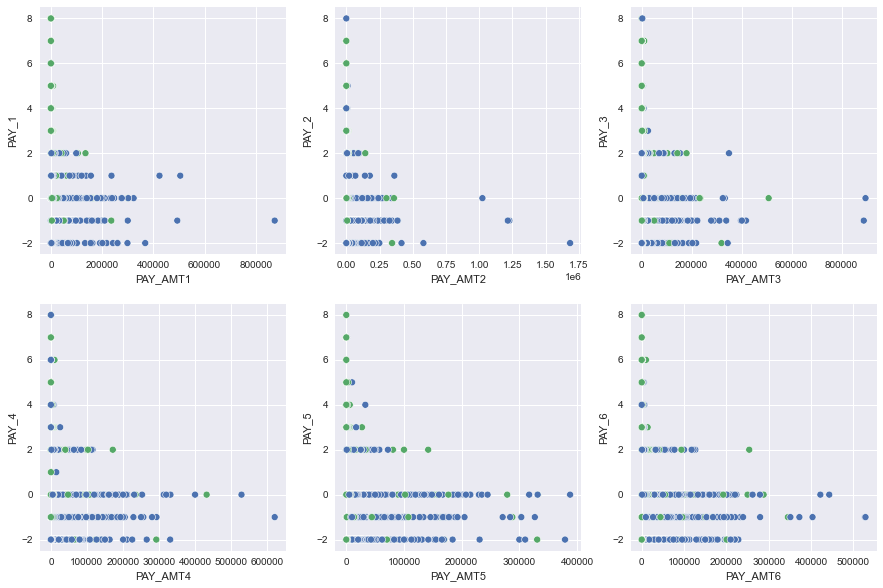

In [76]:
fig,ax = plt.subplots(ncols=3,nrows=2,figsize=(15,10))

for i in range(6):
    sns.scatterplot(df[f'PAY_AMT{i+1}'],df[f'PAY_{i+1}'],ax=ax[i//3][i%3],
                    hue=df['default'],legend=False,x_jitter=True)

### Bill Amount vs Pay Amount

The larger the bill, the less likely bill will be paid in full:

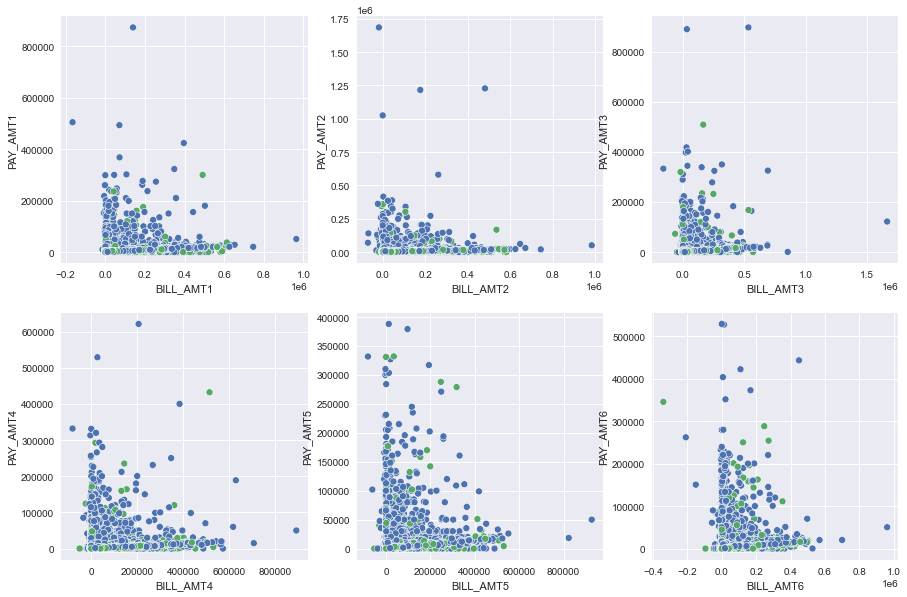

In [77]:
#looking at demographic pair plots
fig,ax = plt.subplots(ncols=3,nrows=2,figsize=(15,10))

for i in range(6):
    sns.scatterplot(df[f'BILL_AMT{i+1}'],df[f'PAY_AMT{i+1}'],ax=ax[i//3][i%3],
                    hue=df['default'],legend=False)

### Demographic Analysis

#### Gender

Men have a slightly higher rate of default than women, but for the most part are similar:

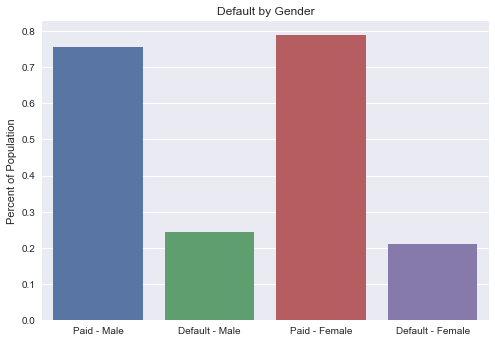

In [81]:
#men have default ratio: ~21% female default, ~24% male default
sns.barplot(['Paid - Male','Default - Male','Paid - Female','Default - Female'],
        df.groupby('SEX').default.value_counts(normalize=True))

df.groupby('SEX').default.value_counts(normalize=True)
plt.title('Default by Gender')
plt.ylabel('Percent of Population')
plt.savefig('./images/gender.png')

#### Education

Broke down by education, the more schooling you have the less likely you are to default. However, its not a very large difference (~6%). The other category may be an anomaly because it has quite a small sample size. 

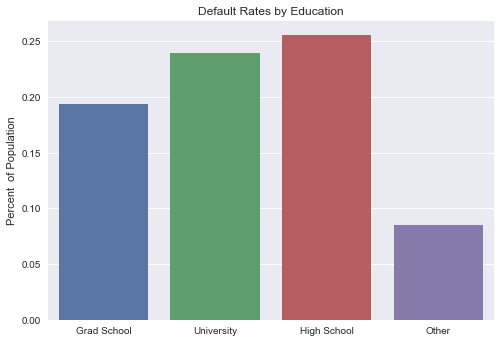

In [82]:
#less schooling, higher rate of default
sns.barplot(['Grad School','University','High School','Other'],
            df.groupby('EDUCATION').default.value_counts(normalize=True).loc[pd.IndexSlice[:,[1]]]
           )

plt.title('Default Rates by Education');
plt.ylabel('Percent  of Population')
plt.savefig('./images/education.png')

#### Marital Status

Single people are also more likely to default than married people:

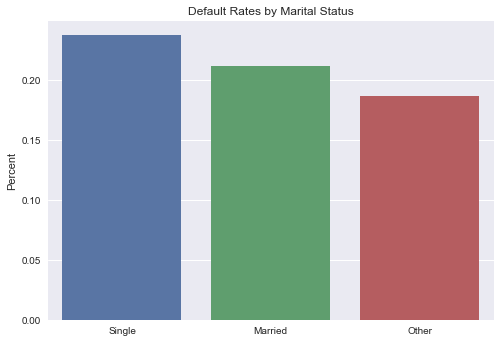

In [84]:
#marital status other than single, lower default rate
sns.barplot(['Single','Married','Other'],
            df.groupby('MARRIAGE').default.value_counts(normalize=True).loc[pd.IndexSlice[:,[1]]]
           )

plt.title('Default Rates by Marital Status');
plt.ylabel('Percent')
plt.savefig('./images/marital.png')

#### Age

People in their late 20s - mid 40s have higher bills (perhaps because of child care costs)

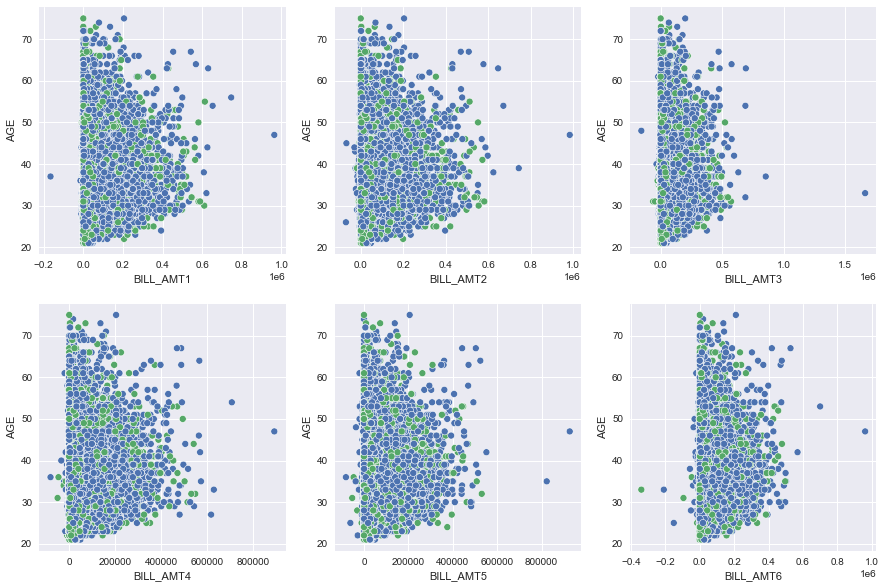

In [35]:
#Age vs Bill
fig,ax = plt.subplots(ncols=3,nrows=2,figsize=(15,10))

for i in range(6):
    sns.scatterplot(df[f'BILL_AMT{i+1}'],df['AGE'],ax=ax[i//3][i%3],
                    hue=df['default'],legend=False)

Younger people also are the people paying 5 - 8 months late. More defaults appear the later the payment (green dots)

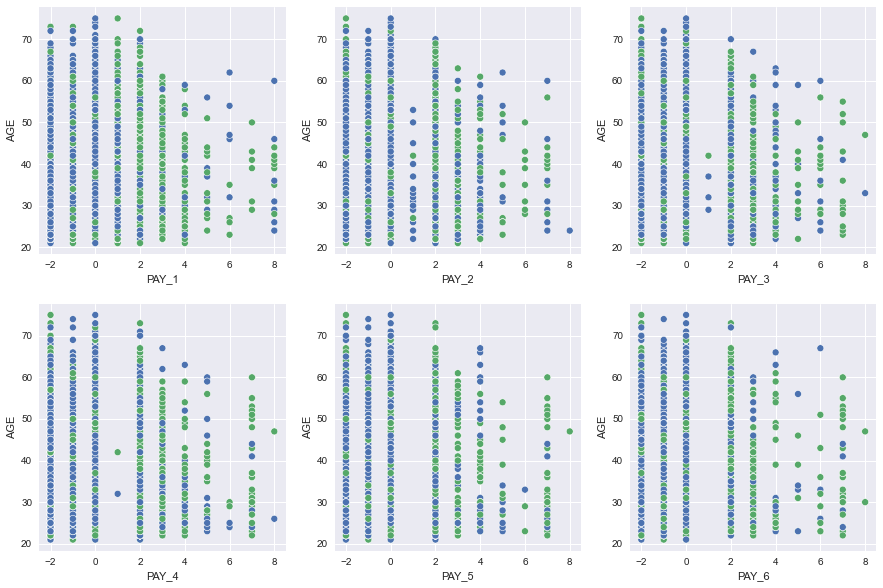

In [36]:
#Age vs Pay
fig,ax = plt.subplots(ncols=3,nrows=2,figsize=(15,10))

for i in range(6):
    sns.scatterplot(df[f'PAY_{i+1}'],df['AGE'],ax=ax[i//3][i%3],
                    hue=df['default'],legend=False)

#### Limit vs balance
People who have balances close to their limit default more (green dots). There also seems to be a max common limit at about \$500,000

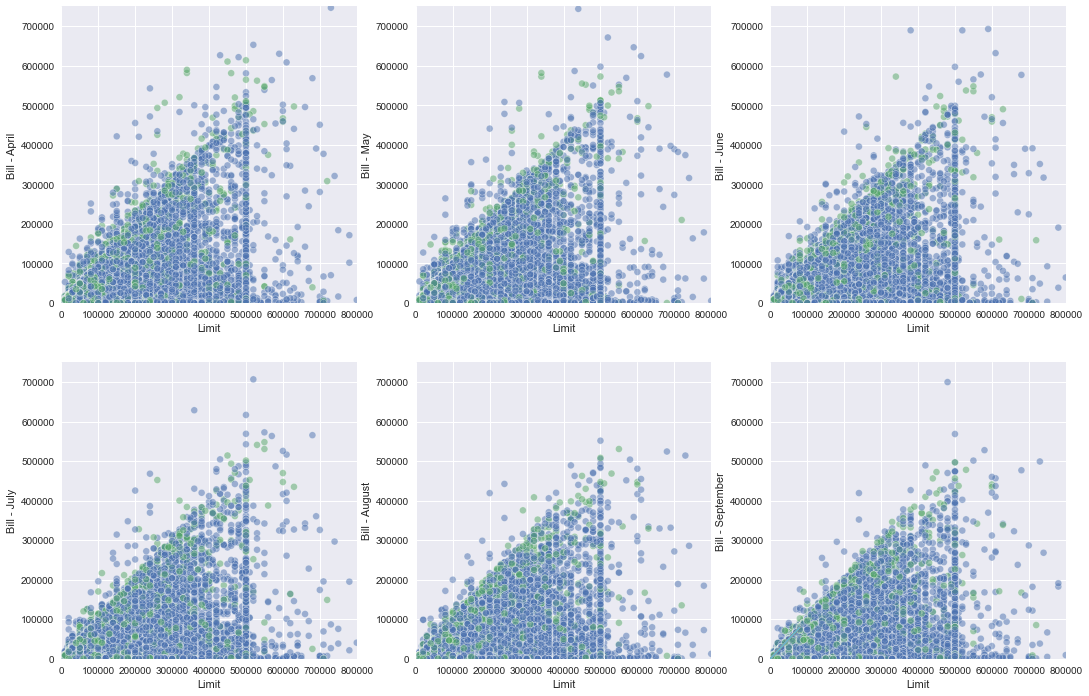

In [96]:
fig,ax = plt.subplots(ncols=3,nrows=2,figsize=(18,12))

months = ['April','May','June','July','August','September']
x= np.linspace(start=0,stop=80000)

for i in range(6):
    sns.scatterplot(df.LIMIT_BAL,df[f'BILL_AMT{i+1}'],ax=ax[i//3][i%3],
                    hue=df['default'],legend=False, alpha=.5)
    ax[i//3][i%3].set_ylabel(f'Bill - {months[i]}')
    ax[i//3][i%3].set_xlabel('Limit')
    ax[i//3][i%3].set_ylim(0,750000)
    ax[i//3][i%3].set_xlim(0,800000)
    
plt.savefig('./images/limit_v_bal.png')

#### Mean Billl & Mean Pay

Most poeple Pay the minimum of ~ \$5000 despite having much larger bills

0.0        3905
2000.0     1012
3000.0      682
5000.0      539
1500.0      394
           ... 
5370.0        1
8140.0        1
16374.0       1
17012.0       1
80.0          1
Name: PAY_AMT1, Length: 6428, dtype: int64


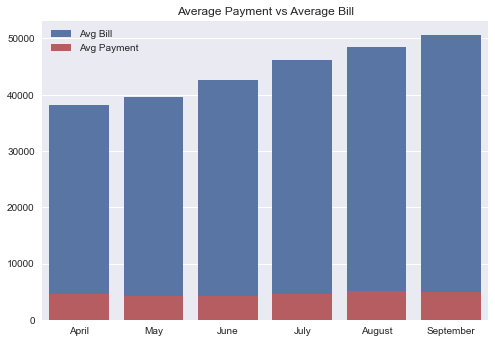

In [59]:
#looks like most people just pay the minimum
mean_bill = [df[f'BILL_AMT{i+1}'].mean() for i in range(6)]
mean_pay = [df[f'PAY_AMT{i+1}'].mean() for i in range(6)]

sns.set_color_codes()

sns.barplot(['April','May','June','July','August','September'],mean_bill[::-1],color='b',label='Avg Bill')
sns.barplot(['April','May','June','July','August','September'],mean_pay[::-1],color='r',label='Avg Payment')
print(df.PAY_AMT1.value_counts())
plt.title('Average Payment vs Average Bill')
plt.legend()
plt.savefig('./images/pay_v_bill.png')

## 3. Handling Major Outliers

Limiting to 99th percentile

In [39]:
for i in range(6):
    df[f'BILL_AMT{i+1}'] = np.where(df[f'BILL_AMT{i+1}'] > df[f'BILL_AMT{i+1}'].quantile(.99),
                                    df[f'BILL_AMT{i+1}'].quantile(.99),
                                    df[f'BILL_AMT{i+1}']
                                   )
    df[f'PAY_AMT{i+1}'] = np.where(df[f'PAY_AMT{i+1}'] > df[f'PAY_AMT{i+1}'].quantile(.99),
                                    df[f'PAY_AMT{i+1}'].quantile(.99),
                                    df[f'PAY_AMT{i+1}']
                                   )

df.LIMIT_BAL = np.where(df.LIMIT_BAL > df.LIMIT_BAL.quantile(.99),
                        df.LIMIT_BAL.quantile(.99),
                       df.LIMIT_BAL)

## 4. Feature Engineering

Percentage Use

In [40]:
for i in range(6):
    df[f'percent_use{i+1}'] = df[f'BILL_AMT{i+1}']/df['LIMIT_BAL']

High limit (>310000 aka 85th quantile) 

In [41]:
df['high_lim'] = np.where(df.LIMIT_BAL > df.LIMIT_BAL.quantile(.85),
                         df.LIMIT_BAL.quantile(.85),
                         df.LIMIT_BAL)

Late or not

In [42]:
for i in range(6):
    df[f'late{i+1}'] = np.where(df[f'PAY_{i+1}'] > 1, 1, 0)

Paid in full

In [43]:
for i in range(6):
    df[f'full{i+1}'] = np.where(df[f'BILL_AMT{i+1}'] - df[f'PAY_AMT{i+1}'] <= 0, 1, 0)

Percentage paid

In [44]:
for i in range(6):
    df[f'percent_pay{i+1}'] = df[f'PAY_AMT{i+1}'] / df[f'BILL_AMT{i+1}']
    df[f'percent_pay{i+1}'] = np.where(df[f'BILL_AMT{i+1}'] <= 0,1,df[f'percent_pay{i+1}'])

Young (<30)

In [45]:
df['young'] = np.where(df.AGE <= 30, 1, 0)

Dummy Variables

In [46]:
df = pd.get_dummies(df,columns=['SEX','EDUCATION','MARRIAGE'],drop_first=True)

In [47]:
df.describe()

,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,...,percent_pay2,percent_pay3,percent_pay4,percent_pay5,percent_pay6,young,SEX_2,EDUCATION_2,EDUCATION_3,EDUCATION_4,MARRIAGE_2,MARRIAGE_3
count,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,...,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000
mean,166382.047202,35.447931,-0.014090,-0.128806,-0.160185,-0.214587,-0.259700,-0.287613,50607.711276,48545.099316,46140.418885,42531.388284,...,1.518133,1.726631,1.592763,1.124451,1.306248,0.369483,0.603227,0.467399,0.165030,0.015601,0.534513,0.012356
std,127707.427930,9.237634,1.123191,1.197954,1.198880,1.174824,1.139984,1.154249,69998.985706,67484.610065,64621.791555,60266.977194,...,35.844420,58.704633,67.973755,10.970432,15.695360,0.482676,0.489239,0.498947,0.371215,0.123927,0.498819,0.110472
min,10000.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-157264.000000,-81334.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3506.000000,2975.000000,2611.500000,2319.500000,...,0.038806,0.033779,0.032926,0.036185,0.036118,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,140000.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22387.000000,21145.000000,20053.000000,19048.000000,...,0.075476,0.062480,0.052742,0.060804,0.066364,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,240000.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,66988.500000,63755.000000,60161.000000,54494.500000,...,0.800313,0.864791,0.829904,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,500000.000000,75.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,354308.040000,341601.140000,325774.340000,305263.480000,...,4444.333333,6333.333333,8887.666667,692.681818,1600.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 5. Train Test Split

**Features & Target**

In [48]:
# Split data to be used in the models
# Create matrix of features
X = df.drop('default', axis = 1) # grabs everything else but y


# Create target variable
y = df['default'] # y is the column we're trying to predict

**Test Train Split**

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [50]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(16874, 52)
(16874,)
(5625, 52)
(5625,)


**Scaling**

In [51]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


## 5. Model Fitting and Hyperparameter Tuning

### KNN

In [339]:
knn = KNeighborsClassifier()

#grid search and cross validation 

grid_params = {
    'n_neighbors': range(3,20,2),
    'weights': ['uniform','distance']
}



knn_grid = GridSearchCV(
    knn,
    grid_params,
    verbose = 1,
    cv = 5,
    n_jobs = -1,
    scoring = 'f1'
)

knn_grid_results = grid.fit(X_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.6min finished


In [340]:
y_pred_knn = knn_grid_results.best_estimator_.predict(X_test)


print(y_pred.shape)
print(y_test.shape)

(5625,)
(5625,)


In [341]:
print(f"""KNN Results
***************************
Best Model: {knn_grid_results.best_estimator_}
Best Train F1:{knn_grid_results.best_score_}
Best Test F1:{f1_score(y_test,y_pred_knn)}
***************************
""")

KNN Results
***************************
Best Model: KNeighborsClassifier(n_neighbors=9, weights='distance')
Best Train F1:0.45291053934274456
Best Test F1:0.469488188976378
***************************



Best KNN had a k of 9 and an F-1 Score that we can use as a base line to compare other models to.

### Logistic Regression

In [342]:
logreg = LogisticRegression(random_state=42)

grid_params = {
    'penalty':['l1','l2'],
    'C':[.25,.5,.75,1,5,10,50,100],
    'class_weight': ['balanced',None]
}

logreg_grid = GridSearchCV(
    logreg, 
    grid_params, 
    scoring='f1',
    cv= 5,
    n_jobs = -1,
    verbose=1
)

logreg_grid_results = logreg_grid.fit(X_train,y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    4.7s finished


In [343]:
y_pred_logreg = logreg_grid_results.best_estimator_.predict(X_test)

print(f"""Logistic Regression Results
***************************
Best Model: {logreg_grid_results.best_estimator_}
Best Train F1:{logreg_grid_results.best_score_}
Best Test F1:{f1_score(y_test,y_pred_logreg)}
***************************
""")

Logistic Regression Results
***************************
Best Model: LogisticRegression(C=5, class_weight='balanced', random_state=42)
Best Train F1:0.5217841458630903
Best Test F1:0.5597173144876324
***************************



The Best logistic regression model performs much better than best KNN with an F1 of .55, let's see if we can improve on with using decision trees.

### Decision Tree

In [344]:
dtc = DecisionTreeClassifier(random_state=42,class_weight='balanced')

grid_params = {
    'max_depth': range(2,10,2),
    'min_samples_split': range(5,30,5),
    'max_leaf_nodes': range(15,65,10),
    'max_features': ['auto','sqrt',None]
}

dtc_grid = GridSearchCV(
    dtc,
    grid_params,
    cv = 5,
    verbose = 1,
    n_jobs=-1,
    scoring='f1'
)

dtc_grid_results = dtc_grid.fit(X_train,y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 1100 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   36.2s finished


In [345]:
y_pred_dtc = dtc_grid_results.best_estimator_.predict(X_test)

print(f"""Decision Tree Results
***************************
Best Model: {dtc_grid_results.best_estimator_}
Best Train F1:{dtc_grid_results.best_score_}
Best Test F1:{f1_score(y_test,y_pred_dtc)}
***************************
""")

Decision Tree Results
***************************
Best Model: DecisionTreeClassifier(class_weight='balanced', max_depth=4, max_leaf_nodes=15,
                       min_samples_split=5, random_state=42)
Best Train F1:0.5140269164938531
Best Test F1:0.5273250239693192
***************************



Doesn't perform quite as well as Logistic Regression

### XGBoost

In [372]:
data_matrix = xgb.DMatrix(data=X,label=y)

In [375]:
xg_model = xgb.XGBClassifier(objective="binary:logistic")

grid_params = {
    "n_estimators":[100,150,200],
    "colsample_bytree":[.25,.5,.75],
    "learning_rate":[.1,.075,.05,.025,.01],
    "max_depth":range(3,8)
}

xgsearch = GridSearchCV(
    estimator= xg_model,
    param_grid= grid_params,
    scoring = 'f1',
    n_jobs=-1,
    verbose=1,
    cv=5
)

In [381]:
xgsearch.fit(X_train,y_train)

Fitting 5 folds for each of 225 candidates, totalling 1125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
ERROR:concurrent.futures:exception calling callback for <Future at 0x7ffe53b2e240 state=finished raised BrokenProcessPool>
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/Users/mitchellkrieger/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py", line 404, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "/Users/mitchellkrieger/opt/anaconda3/envs/learn-env/lib/python3.6/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
ModuleNotFoundError: No module named 'sklearn.metrics._scorer'
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/mitchellkrieger/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
 

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

## Ensemble methods
### Random Forest

In [351]:
forest = RandomForestClassifier(random_state=42,class_weight='balanced')

grid_params = {
    'n_estimators':[50,100,500,1000,5000]
    'max_depth': range(2,10,2),
    'min_samples_split': range(5,30,5),
    'max_leaf_nodes': range(15,65,10),
    'max_features': ['auto','sqrt',None]
    'max_samples': [None,.25,.5,.75,.9]
}

forest_grid = GridSearchCV(
    forest,
    grid_params,
    cv=5,
    verbose=1
    n_jobs=-1
    scoring='f1'
)

forest_grid_results = forest_grid.fit(X_train,y_train)

Fitting 5 folds for each of 2880 candidates, totalling 14400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 42.7min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 60.2min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 70.5min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 83.7min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 148.8min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 166.6min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 195.1min
[Parallel(n_jobs=-1)]: Done 11234 tasks    

In [352]:
y_pred_forest = forest_grid_results.best_estimator_.predict(X_test)

print(f"""Random Forrest Results
***************************
Best Model: {forest_grid_results.best_estimator_}
Best Train F1:{forest_grid_results.best_score_}
Best Test F1:{f1_score(y_test,y_pred_forest)}
***************************
""")

Random Forrest Results
***************************
Best Model: RandomForestClassifier(class_weight='balanced', max_depth=6, max_leaf_nodes=35,
                       max_samples=0.75, min_samples_split=25, random_state=42)
Best Train F1:0.5366200068723923
Best Test F1:0.5607207207207208
***************************



The Random Forrest performs the best so far with an F1 score of 0.56. The parameters associated witht this model are:

In [353]:
forest_grid_results.best_params_

{'max_depth': 6,
 'max_features': 'auto',
 'max_leaf_nodes': 35,
 'max_samples': 0.75,
 'min_samples_split': 25,
 'n_estimators': 100}

### Ensemble Voting

Let's try combining the best KNN, logistic regression and decision tree

In [459]:
best_knn = knn_grid_results.best_estimator_
best_logreg = logreg_grid_results.best_estimator_
best_dtc = dtc_grid_results.best_estimator_

voter = VotingClassifier(estimators=[('knn',best_knn),('logreg',best_logreg),('tree',best_dtc)],
                        voting='soft')

voter.fit(X_train,y_train)

y_train_pred = voter.predict(X_train)
y_test_pred = voter.predict(X_test)


print(f"""Voting Results
***************************
Enseble Model: {voter}
Train F1:{f1_score(y_train,y_train_pred)}
Test F1:{f1_score(y_test,y_test_pred)}
***************************
""")

Voting Results
***************************
Enseble Model: VotingClassifier(estimators=[('knn',
                              KNeighborsClassifier(n_neighbors=9,
                                                   weights='distance')),
                             ('logreg',
                              LogisticRegression(C=5, class_weight='balanced',
                                                 random_state=42)),
                             ('tree',
                              DecisionTreeClassifier(class_weight='balanced',
                                                     max_depth=4,
                                                     max_leaf_nodes=15,
                                                     min_samples_split=5,
                                                     random_state=42))],
                 voting='soft')
Train F1:0.9062267427437359
Test F1:0.5420482930890924
***************************



Adding in the best random forest:

In [461]:
voter2 = VotingClassifier(estimators=[('knn',best_knn),('logreg',best_logreg),('tree',best_dtc),('forest',best_forest)],
                        voting='hard')

voter2.fit(X_train,y_train)

y_train_pred = voter.predict(X_train)
y_test_pred = voter.predict(X_test)


print(f"""Voting Results
***************************
Enseble Model: {voter2}
Train F1:{f1_score(y_train,y_train_pred)}
Test F1:{f1_score(y_test,y_test_pred)}
***************************
""")

Voting Results
***************************
Enseble Model: VotingClassifier(estimators=[('knn',
                              KNeighborsClassifier(n_neighbors=9,
                                                   weights='distance')),
                             ('logreg',
                              LogisticRegression(C=5, class_weight='balanced',
                                                 random_state=42)),
                             ('tree',
                              DecisionTreeClassifier(class_weight='balanced',
                                                     max_depth=4,
                                                     max_leaf_nodes=15,
                                                     min_samples_split=5,
                                                     random_state=42)),
                             ('forest',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_dept

## 7. Final Model Export for Holdout predicisons

In [27]:
import pickle

In [54]:
modelf1

,model,train_f1,test_f1
0,Random Forrest,0.535071,0.563662


In [55]:
best_forest

RandomForestClassifier(class_weight='balanced', max_depth=6, max_leaf_nodes=35,
                       max_samples=0.75, min_samples_split=25, random_state=42)

In [56]:
scaler

StandardScaler()

In [57]:
pickle_out = open('model.pickle','wb')
pickle.dump(best_forest,pickle_out)
pickle_out.close()

In [58]:
pickle_out = open('scaler.pickle','wb')
pickle.dump(scaler,pickle_out)
pickle_out.close()